In [1]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from scipy.stats import hmean
# import xgboost as xgb
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, average_precision_score
import re
import helper_functions
import seaborn as sns

In [2]:
# load data and filter simultaneously
DFVZ_PATH = '../DataFiles/experimental_data_set.csv'
DF20_PATH = '../DataFiles/df20.csv'

dfvz, df20 = helper_functions.load_and_filter_dataset(DFVZ_PATH, DF20_PATH, 'CPXXX')

/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)



    DF Contains: 
    Sequences Containing C: 2740
    Sequences Containing PXXX (Not PPXX): 4328
    Combine the two above filters with or: 6846 
    
Len Before Filtering for DFVZ and DF20: [67278 67278]
Len After Filter: [60432 60432]


In [3]:
# Scale and Pre-process data: This will store the various pre-processed forms of the data as dictionaries that can be
# use to easily access the data for different purposes.

X_dict, Xname_dict, y_dict = helper_functions.pre_process_data(dfvz=dfvz, df20=df20, threshold=.05)


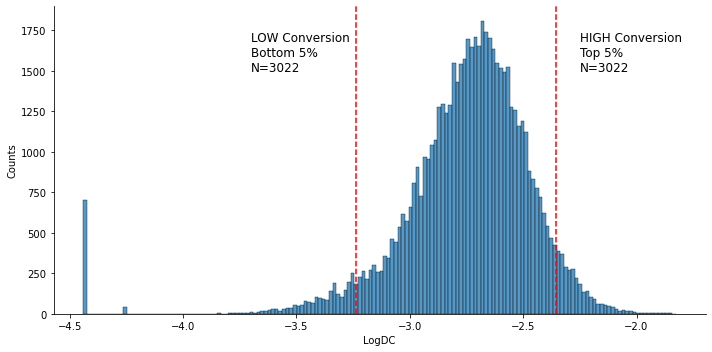

In [61]:
# Plot the distribution

LOW_QUANTILE = dfvz['log.label'].quantile(0.05)
HIGH_QUANTILE = dfvz['log.label'].quantile(0.95)

g = sns.displot(dfvz['log.label'], kind='hist', height=5, aspect=2)

g.set_axis_labels("LogDC", "Counts")
g.set_titles("Distribution of LogDC Values with HIGH and LOW Class")
plt.axvline(LOW_QUANTILE, color='red', linestyle='--')
plt.axvline(HIGH_QUANTILE, color='red', linestyle='--')
plt.text(-3.7, 1500, 'LOW Conversion\nBottom 5%\nN=3022', fontsize='large', )
plt.text(-2.25, 1500, 'HIGH Conversion\nTop 5%\nN=3022', fontsize='large' )

plt.savefig(f'figures/Class_Distribution.svg')
plt.savefig(f'figures/Class_Distribution.png', dpi=300)


In [4]:
# Set optimized hyper params for the models:
model_params = {
    'gamma':0, #1 no effect
    'learning_rate':0.1,
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'n_estimators':200,
    'subsample':1,
    'colsample_bytree': 0.4,
    'colsample_bylevel':1,
    'random_state':42,
    'scale_pos_weight':6,
    'reg_alpha': 0 ,
    'reg_lambda':1,
    'base_score':0.5,
    'n_jobs':-1
}

# Set features for High Classifier - Will be used to evaluate and then save the final model:

X = X_dict['Xpvz_s'] # X now contains scaled features from both pattern and chemical feature datasets
y = y_dict['high'] # y now contains labels for the top 5 percentile vs the other 95%

skf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mod_high = xgb.XGBClassifier(
   **model_params
)

Index(['..AA', '..AR', '..AN', '..AD', '..AC', '..AE', '..AQ', '..AG', '..AH',
       '..AI',
       ...
       'M...', 'F...', 'P...', 'S...', 'T...', 'W...', 'Y...', 'V...', 'seq',
       'label'],
      dtype='object', length=2398)
Index(['seq', 'label', 'log.label', 'z1.1', 'z1.2', 'z1.3', 'z2.1', 'z2.2',
       'z2.3', 'z3.1', 'z3.2', 'z3.3', 'z4.1', 'z4.2', 'z4.3', 'vhse1.1',
       'vhse1.2', 'vhse1.3', 'vhse1.4', 'vhse1.5', 'vhse1.6', 'vhse1.7',
       'vhse1.8', 'vhse2.1', 'vhse2.2', 'vhse2.3', 'vhse2.4', 'vhse2.5',
       'vhse2.6', 'vhse2.7', 'vhse2.8', 'vhse3.1', 'vhse3.2', 'vhse3.3',
       'vhse3.4', 'vhse3.5', 'vhse3.6', 'vhse3.7', 'vhse3.8', 'vhse4.1',
       'vhse4.2', 'vhse4.3', 'vhse4.4', 'vhse4.5', 'vhse4.6', 'vhse4.7',
       'vhse4.8'],
      dtype='object')


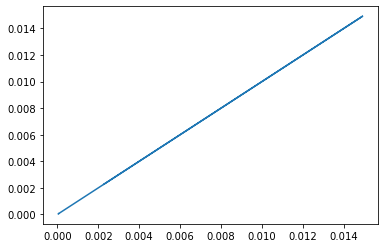

In [5]:
#sanity checks
print(df20.iloc[:,:].columns)
print(dfvz.iloc[:,:].columns)
print(plt.plot(dfvz['label'], df20['label']))

Fold #: 1
acc score: 0.92
roc score: 0.80
f1 score: 0.33
Precision score: 0.30
Recall score: 0.38
Average precision-recall score: 0.30


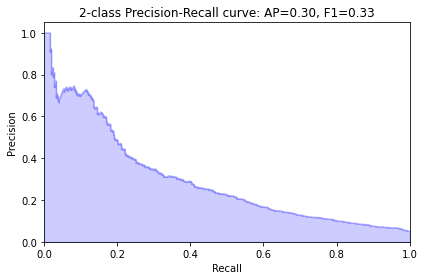

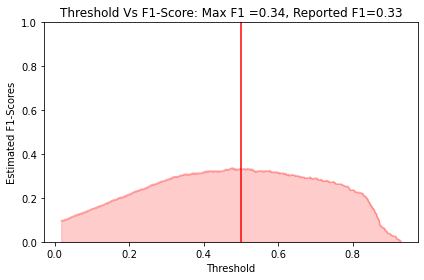

Recall: 0.38
Precision: 0.30


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,10945,537
Positive,377,228


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


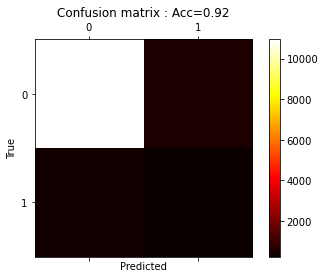

--------------------------------------------------------
Fold #: 2
acc score: 0.92
roc score: 0.80
f1 score: 0.33
Precision score: 0.29
Recall score: 0.38
Average precision-recall score: 0.27


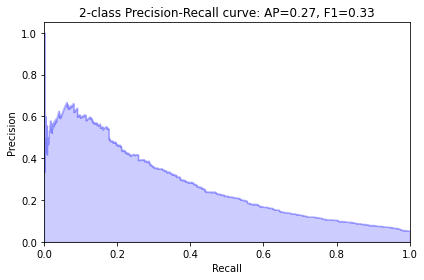

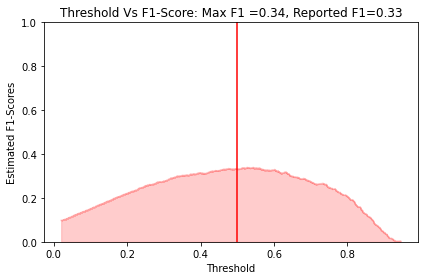

Recall: 0.38
Precision: 0.29


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,10935,547
Positive,377,228


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


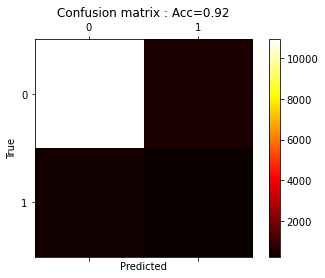

--------------------------------------------------------
Fold #: 3
acc score: 0.93
roc score: 0.81
f1 score: 0.35
Precision score: 0.31
Recall score: 0.41
Average precision-recall score: 0.27


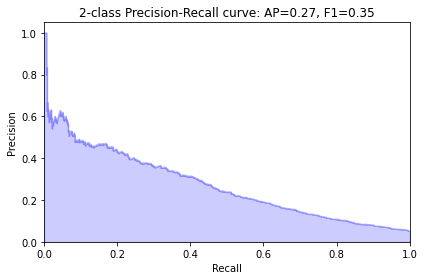

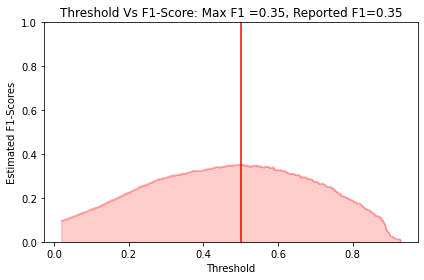

Recall: 0.41
Precision: 0.31


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,10937,545
Positive,358,246


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


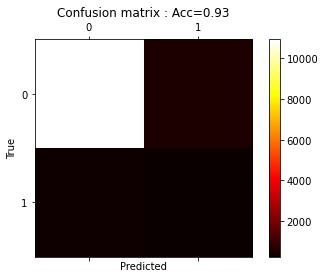

--------------------------------------------------------
Fold #: 4
acc score: 0.92
roc score: 0.81
f1 score: 0.31
Precision score: 0.29
Recall score: 0.34
Average precision-recall score: 0.26


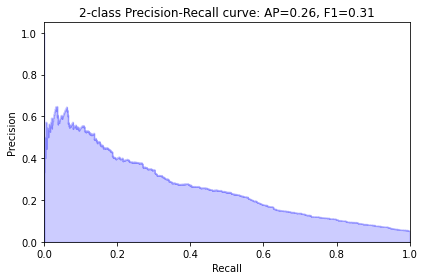

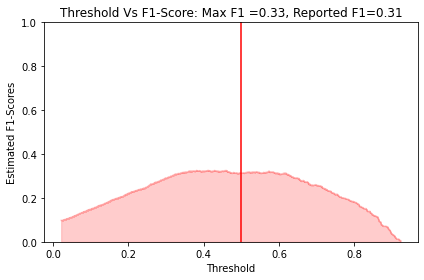

Recall: 0.34
Precision: 0.29


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,10966,516
Positive,396,208


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


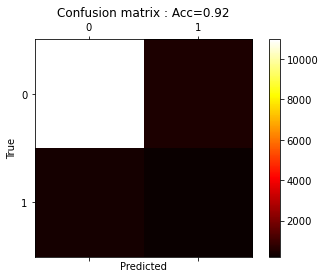

--------------------------------------------------------
Fold #: 5
acc score: 0.92
roc score: 0.81
f1 score: 0.32
Precision score: 0.29
Recall score: 0.37
Average precision-recall score: 0.29


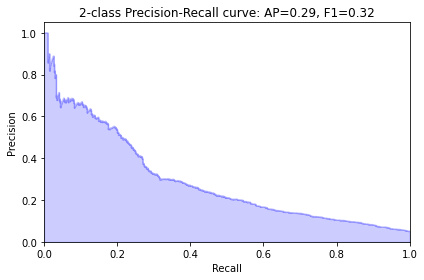

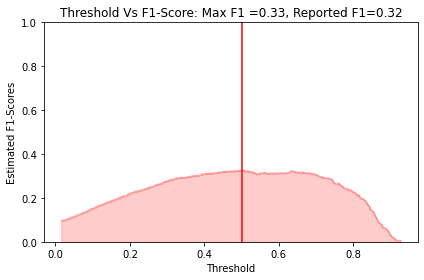

Recall: 0.37
Precision: 0.29


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,10921,561
Positive,378,226


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


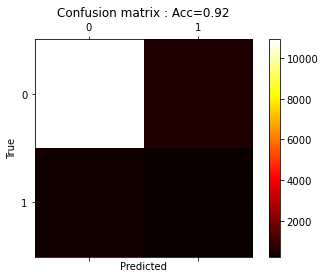

--------------------------------------------------------


In [6]:
# Evaluate HIGH Model
acc_dict = {}
roc_dict = {}
f1_dict = {}
prec_dict ={}
rec_dict ={}
aprec_dict = {}
i = 0

for train_index, test_index in skf5.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    i = i + 1

    print ('Fold #: ' + str(i))
    mod_high.fit(X_train, y_train)

    y_pred = mod_high.predict(X_test)
    y_score = mod_high.predict_proba(X_test)[:,1]

    acc_dict[i] = (y_pred == y_test).mean()
    roc_dict[i] = roc_auc_score(y_test, y_score)
    f1_dict[i] = f1_score(y_test, y_pred, average='binary')
    prec_dict[i] = precision_score(y_test, y_pred)
    rec_dict[i] = recall_score(y_test, y_pred)
    aprec_dict[i] = average_precision_score(y_test, y_score)

    print("acc score: {0:,.2f}".format(acc_dict[i]))
    print("roc score: {0:,.2f}".format(roc_dict[i]))
    print("f1 score: {0:,.2f}".format(f1_dict[i]))
    print("Precision score: {0:,.2f}".format(prec_dict[i]))
    print("Recall score: {0:,.2f}".format(rec_dict[i]))
    print('Average precision-recall score: {0:,.2f}'.format(aprec_dict[i]))

    #Plot the results
    helper_functions.evalplots(y_test,y_score,y_pred,[0, 1],f'HIGH_FOLD_{i}_CV')

In [7]:
for dt in [acc_dict,roc_dict,f1_dict,prec_dict,rec_dict,aprec_dict]:
    print(np.mean(list(dt.values())))
    print(np.std(list(dt.values())))
    print()


0.9240137690584348
0.0010153939324350821

0.8067942886067891
0.0032529407590227892

0.3308337527967588
0.012849699989961818

0.29553815448448423
0.008776830631881186

0.37590936456679985
0.019919420109338695

0.27963172559890836
0.013376269814568536



acc score: 0.94
roc score: 0.91
f1 score: 0.44
Precision score: 0.39
Recall score: 0.51
Average precision-recall score: 0.43


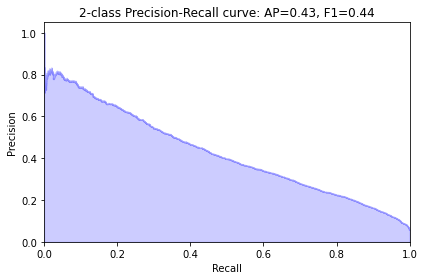

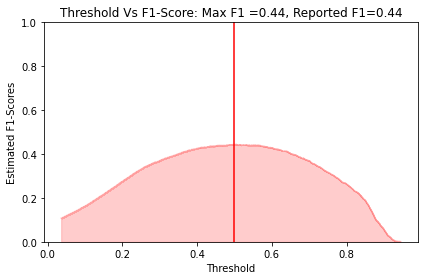

Recall: 0.51
Precision: 0.39


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,55013,2397
Positive,1478,1544


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


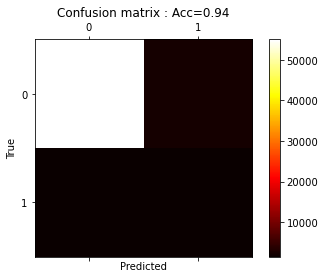

--------------------------------------------------------


In [8]:
#fit model to entire sample
mod_high = xgb.XGBClassifier(
    **model_params
)

mod_high.fit(X, y)

#training accuracy
y_pred = mod_high.predict(X)
y_score = mod_high.predict_proba(X)[:,1]

acc = (y_pred == y).mean()
roc = roc_auc_score(y, y_score)
f1 = f1_score(y, y_pred, average='binary')
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
aprec = average_precision_score(y, y_score)

print("acc score: {0:,.2f}".format(acc))
print("roc score: {0:,.2f}".format(roc))
print("f1 score: {0:,.2f}".format(f1))
print("Precision score: {0:,.2f}".format(prec))
print("Recall score: {0:,.2f}".format(rec))
print('Average precision-recall score: {0:,.2f}'.format(aprec))

#Plot the results
helper_functions.evalplots(y,y_score,y_pred,[0, 1], 'HIGH_FULL')

In [9]:
#save model to file
pickle.dump(mod_high, open("models/npx_mod_high_xgb_cor.pickle", "wb"))

## Low Model

In [10]:
mod_low = xgb.XGBClassifier(
    **model_params
)
X = X_dict['Xpvz_s'] # X now contains scaled features from both pattern and chemical feature datasets
y = y_dict['low'] # y now contains labels for the top 5 percentile vs the other 95%

Fold #: 1
acc score: 0.93
roc score: 0.71
f1 score: 0.13
Precision score: 0.16
Recall score: 0.11
Average precision-recall score: 0.12


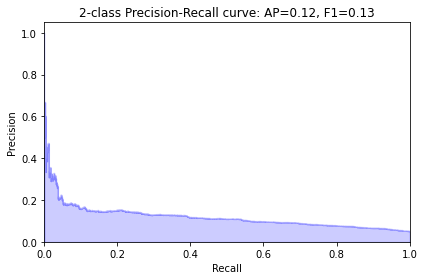

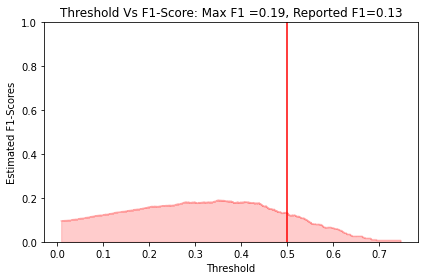

Recall: 0.11
Precision: 0.16


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,11146,336
Positive,539,66


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


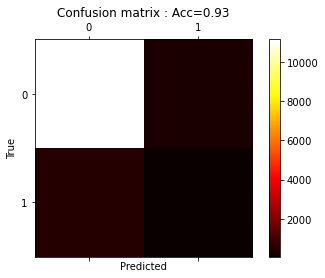

--------------------------------------------------------
Fold #: 2
acc score: 0.93
roc score: 0.74
f1 score: 0.14
Precision score: 0.17
Recall score: 0.11
Average precision-recall score: 0.13


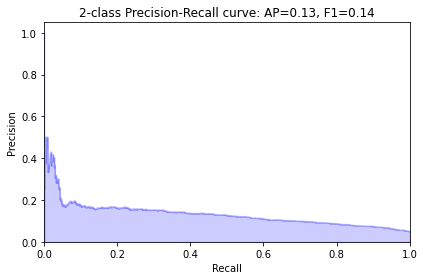

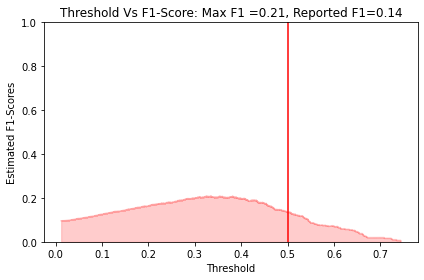

Recall: 0.11
Precision: 0.17


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,11138,344
Positive,536,69


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


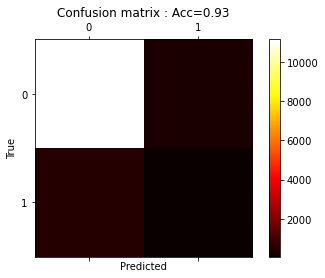

--------------------------------------------------------
Fold #: 3
acc score: 0.93
roc score: 0.73
f1 score: 0.11
Precision score: 0.15
Recall score: 0.09
Average precision-recall score: 0.12


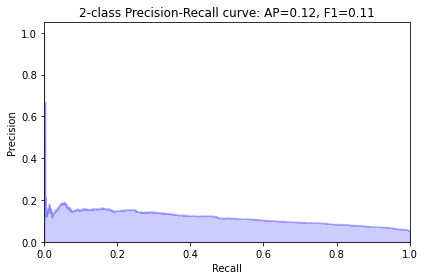

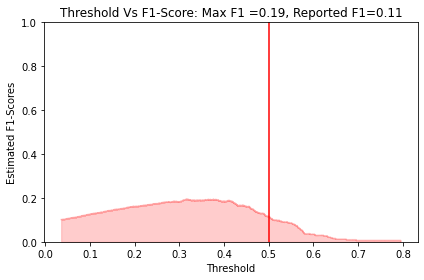

Recall: 0.09
Precision: 0.15


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,11176,306
Positive,549,55


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


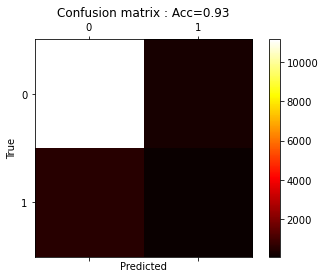

--------------------------------------------------------
Fold #: 4
acc score: 0.93
roc score: 0.73
f1 score: 0.13
Precision score: 0.18
Recall score: 0.11
Average precision-recall score: 0.13


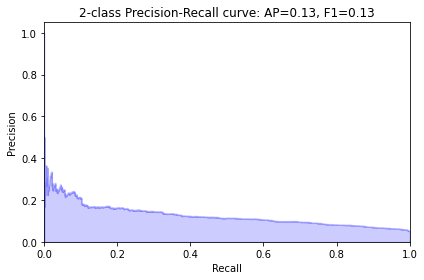

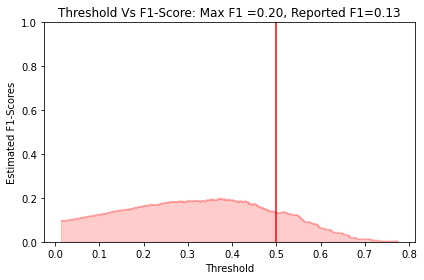

Recall: 0.11
Precision: 0.18


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,11186,296
Positive,539,65


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


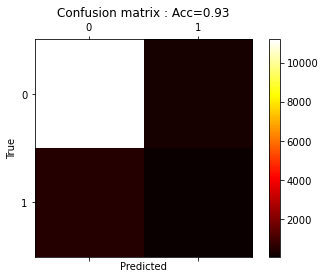

--------------------------------------------------------
Fold #: 5
acc score: 0.93
roc score: 0.73
f1 score: 0.13
Precision score: 0.17
Recall score: 0.11
Average precision-recall score: 0.12


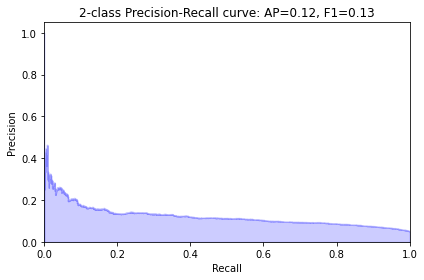

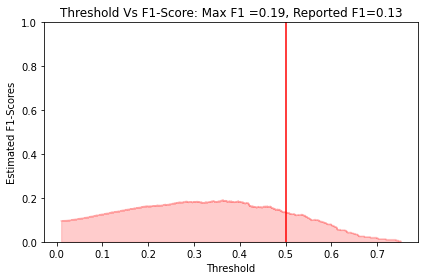

Recall: 0.11
Precision: 0.17


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,11145,337
Positive,536,68


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


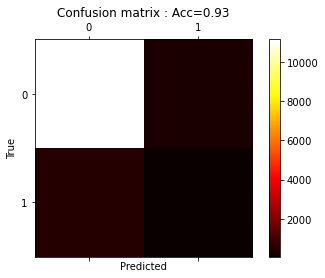

--------------------------------------------------------


In [12]:
# Evaluate LOW Model
acc_dict = {}
roc_dict = {}
f1_dict = {}
prec_dict ={}
rec_dict ={}
aprec_dict = {}
i = 0

for train_index, test_index in skf5.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    i = i + 1

    print ('Fold #: ' + str(i))
    mod_low.fit(X_train, y_train)

    y_pred = mod_low.predict(X_test)
    y_score = mod_low.predict_proba(X_test)[:,1]

    acc_dict[i] = (y_pred == y_test).mean()
    roc_dict[i] = roc_auc_score(y_test, y_score)
    f1_dict[i] = f1_score(y_test, y_pred, average='binary')
    prec_dict[i] = precision_score(y_test, y_pred)
    rec_dict[i] = recall_score(y_test, y_pred)
    aprec_dict[i] = average_precision_score(y_test, y_score)

    print("acc score: {0:,.2f}".format(acc_dict[i]))
    print("roc score: {0:,.2f}".format(roc_dict[i]))
    print("f1 score: {0:,.2f}".format(f1_dict[i]))
    print("Precision score: {0:,.2f}".format(prec_dict[i]))
    print("Recall score: {0:,.2f}".format(rec_dict[i]))
    print('Average precision-recall score: {0:,.2f}'.format(aprec_dict[i]))

    #Plot the results
    helper_functions.evalplots(y_test,y_score,y_pred,[0, 1], f'LOW_FOLD_{i}_CV')

In [13]:
for dt in [acc_dict,roc_dict,f1_dict,prec_dict,rec_dict,aprec_dict]:
    print(np.mean(list(dt.values())))
    print(np.std(list(dt.values())))
    print()

0.9285478271937686
0.0013721773637090685

0.7303060961575703
0.010627974425848051

0.13002678508120788
0.008167723586468001

0.16631210585247153
0.008846928595169518

0.10687975480269278
0.008241836227266167

0.12333849939702546
0.005457659697390101



acc score: 0.94
roc score: 0.88
f1 score: 0.33
Precision score: 0.39
Recall score: 0.29
Average precision-recall score: 0.32


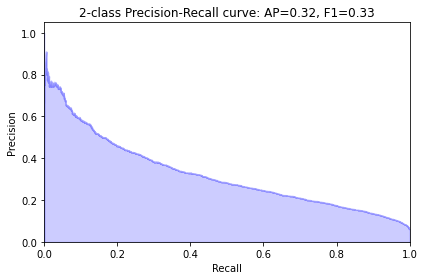

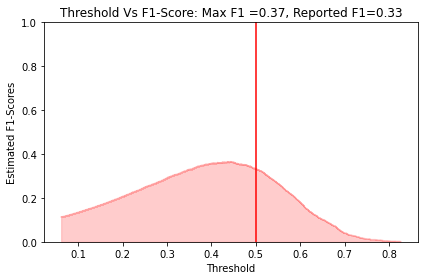

Recall: 0.29
Precision: 0.39


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,56080,1330
Positive,2157,865


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


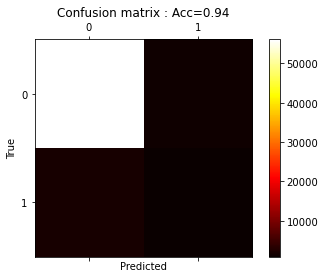

--------------------------------------------------------


In [14]:
#fit model to entire sample (low model)
mod_low = xgb.XGBClassifier(
    **model_params
)

mod_low.fit(X, y)

#training accuracy
y_pred = mod_low.predict(X)
y_score = mod_low.predict_proba(X)[:,1]

acc = (y_pred == y).mean()
roc = roc_auc_score(y, y_score)
f1 = f1_score(y, y_pred, average='binary')
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
aprec = average_precision_score(y, y_score)

print("acc score: {0:,.2f}".format(acc))
print("roc score: {0:,.2f}".format(roc))
print("f1 score: {0:,.2f}".format(f1))
print("Precision score: {0:,.2f}".format(prec))
print("Recall score: {0:,.2f}".format(rec))
print('Average precision-recall score: {0:,.2f}'.format(aprec))

#Plot the results
helper_functions.evalplots(y,y_score,y_pred,[0, 1], 'LOW_FULL')

In [15]:
#save model to file
pickle.dump(mod_low, open("models/npx_mod_low_xgb_cor.pickle", "wb"))

In [62]:
# This mode allows for backwards and forwards compatibility
mod_low.save_model('models/xgb_low_model.json')
mod_high.save_model('models/xgb_high_model.json')

## Use Final Models to Make Predictions:

1. Load 160k data set with features (feats)0.0
2. Run both HIGH and LOW models on data to create probability and predictions
3. Label sequences that we already know log dc values for add them.
4. Label all sequences that contain PXXX and C. Not PPXX

In [63]:
# Load 160k observations to be classified (these were constructed via a function, please see
# TODO helper_functions -> loadextdict
feats = pickle.load(open("../DataFiles/feature_160k.pickle", "rb"))

# Generate predictions (probabilities)
low_probs = mod_low.predict_proba(feats.values)[:,1]
high_probs = mod_high.predict_proba(feats.values)[:,1]

In [67]:
pred_df = pd.DataFrame(index=feats.index)
pred_df['low_probs']=low_probs
pred_df['high_probs'] = high_probs


In [69]:
# Label sequences containing PXXX and C (Not PPXX)
pred_df['Filter(C)and(PXXX)'] = False
filter_c_pxxx = pred_df.index.str.contains('(^P[^P])|([C])')
pred_df.loc[filter_c_pxxx, 'Filter(C)and(PXXX)'] = True

/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [81]:
# Add a new column with known logDC values
dfvz.set_index('seq', inplace=True)
combined = pd.concat([pred_df, dfvz['log.label']], axis=1, join='outer')

# Save df:
combined.to_csv('Predictions-160-Probabilities.csv')

## Load Predictions

We can load the predictions we made earlier by using the code block below. By using these predictions, we can create a 20x20 plot that shows the trend across the un-observed sequences. 

1. Load Predictions
2. Visualize the probabilities themselves as 20x20 plots for each of the HIGH and LOW Class. 
3. The probabilities can not be compared directly with the logDC values in the observed data. As such, convert the observed logDC values to their corresponding labels used for training
    * HIGH - Top 5%
    * MEDIUM - Middle 90%
    * LOW - Bottom 5%
4. Convert the probability distributions to actual predictions by using a 0.5 threshold. Combine the predictions as follows: 
    * If LOW_Prob > 0.5 and HIGH_Prob < 0.5 -> Low Class
    * If HIGH_Prob > 0.5 and LOW_Prob < 0.5 -> High Class
    * If Low_Prob < 0.5 and High_Prob < 0.5 -> Medium Class
5. Visualize the predictions and observed values as two 20x20 plots. Do this for both filtered and unfiltered predictions. 

In [14]:
#Load outputted data:
pred_df = pd.read_csv('ouptput/Predictions-160-Probabilities.csv', index_col = 0)

# Create two new dfs that only have probability values
pred_df_high = pred_df['high_probs']
pred_df_low = pred_df['low_probs']

This part worked!


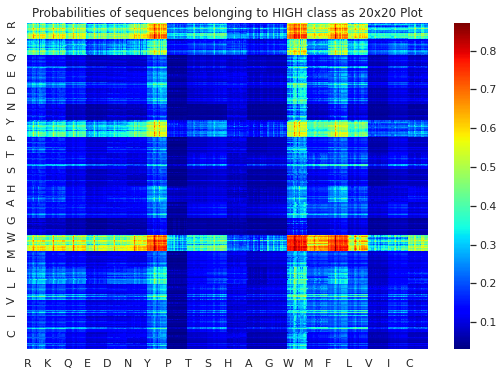

In [5]:
TITLE = 'Probabilities of sequences belonging to HIGH class as 20x20 Plot'
high_probs_20_20_plot = helper_functions.ttplot(pred_df_high.index, pred_df_high.values, title=TITLE)
high_probs_20_20_plot.tight_layout()
high_probs_20_20_plot.savefig('20x20_high_probs_100.png')

This part worked!


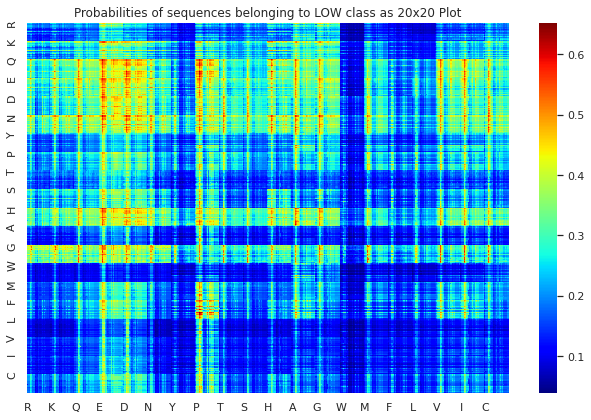

In [6]:
TITLE = 'Probabilities of sequences belonging to LOW class as 20x20 Plot'
low_probs_20_20_plot = helper_functions.ttplot(pred_df_low.index, pred_df_low.values, title=TITLE)
low_probs_20_20_plot.tight_layout()
low_probs_20_20_plot.savefig('20x20_low_probs_100.png')

In [18]:
# Filter our data set for PXXX (not PPXX) and Sequences containing Cysteines

filter_c_pxxx = pred_df_high.index.str.contains('(^P[^P])|([C])')
idx_inverted = pred_df_high[~filter_c_pxxx].index.to_list()

filtered_high_probs = pred_df_high[idx_inverted]
filtered_low_probs = pred_df_low[idx_inverted]

This part worked!


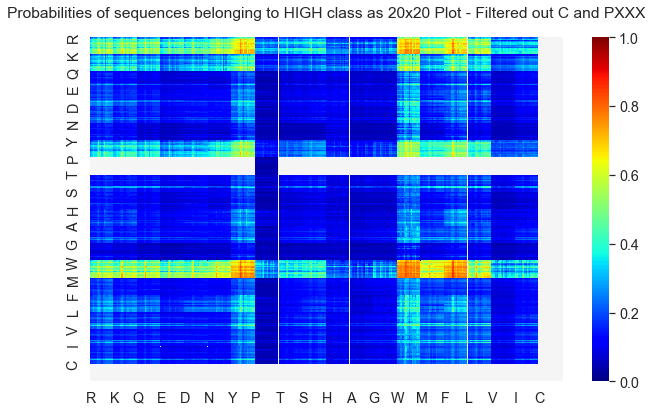

In [19]:
TITLE = 'Probabilities of sequences belonging to HIGH class as 20x20 Plot - Filtered out C and PXXX'
high_probs_20_20_plot = helper_functions.ttplot(filtered_high_probs.index, filtered_high_probs.values, title=TITLE, vmin=0.0 , vmax=1.0)
high_probs_20_20_plot.tight_layout()
high_probs_20_20_plot.savefig('20x20_high_probs_filtered_100.png')

This part worked!


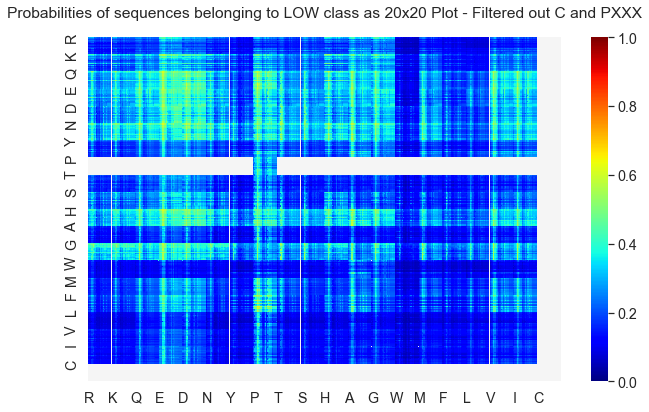

In [20]:
TITLE = 'Probabilities of sequences belonging to LOW class as 20x20 Plot - Filtered out C and PXXX'
low_probs_20_20_plot = helper_functions.ttplot(filtered_low_probs.index, filtered_low_probs.values, title=TITLE ,vmin=0.0 , vmax=1.0)
low_probs_20_20_plot.tight_layout()
low_probs_20_20_plot.savefig('20x20_low_probs_filtered_100.png')

This part worked!


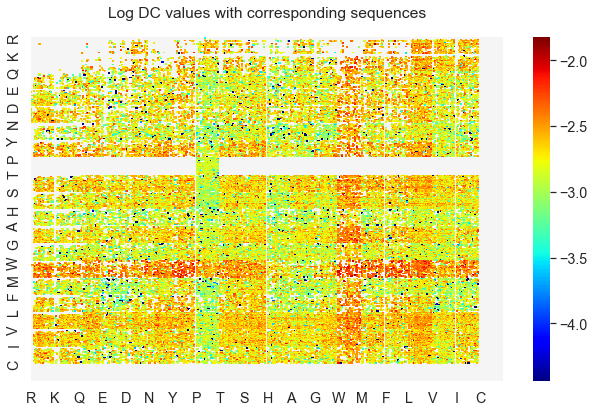

In [21]:
TITLE = 'Log DC values with corresponding sequences'
original_20_20_plot = helper_functions.ttplot(pred_df.index, pred_df['log.label'].values, title=TITLE)
original_20_20_plot.tight_layout()
original_20_20_plot.savefig('20x20_log_dc_original_data.png')

## Convert logDC values and Probabilities to Class Labels

1. First convert logDC values to class labels:
    * 1 - Top 5%
    * -1 - Bottom 5%
    * 0 - Middle 90% 
2. Convert the probability distributions to actual predictions by using a 0.5 threshold. Combine the predictions as follows: 
    * If LOW_Prob > 0.5 and HIGH_Prob < 0.5 -> Low Class
    * If HIGH_Prob > 0.5 and LOW_Prob < 0.5 -> High Class
    * If Low_Prob < 0.5 and High_Prob < 0.5 -> Medium Class
3. Visualize the observed and predicted data as 20x20 plots

In [22]:
# Add threshold values for log.label
top_5_quantile = pred_df['log.label'].quantile(q=0.95)
bot_5_quantile = pred_df['log.label'].quantile(q=0.05)

In [23]:
conditions_log = [
    (pred_df['log.label'] <= bot_5_quantile),
    (pred_df['log.label'] >= top_5_quantile),
    (pred_df['log.label'] < top_5_quantile) & (pred_df['log.label'] > bot_5_quantile)
]

values_cond_log = [-1, 1, 0]

pred_df['combined_gt'] = np.select(conditions_log, values_cond_log)

In [29]:
conditions = [
    (pred_df['low_probs'] >= 0.5) & (pred_df['high_probs'] < 0.5),
    (pred_df['high_probs'] >= 0.5) & (pred_df['low_probs'] < 0.5),
    (pred_df['low_probs'] < 0.5) & (pred_df['high_probs'] < 0.5)
]

values_cond = [-1, 1, 0]

pred_df['combined_pred'] = np.select(conditions, values_cond) # Assign prediction labels
pred_df_gt = pred_df[~pred_df['log.label'].isna()] # Ground truth -> Only contains observed data
pred_df_pred = pred_df[pred_df['log.label'].isna()] # Predictions -> only contains predicted data

print(f'Value Counts for Ground Truth:\n{pred_df_gt.combined_gt.value_counts()}\n', '*' * 40)
print(f'Value Counts for Predictions:\n{pred_df_pred.combined_pred.value_counts()}\n', '*' * 40)

Value Counts for Ground Truth:
 0    54388
 1     3022
-1     3022
Name: combined_gt, dtype: int64
 ****************************************
Value Counts for Predictions:
 0    93410
 1     5004
-1     1154
Name: combined_pred, dtype: int64
 ****************************************


This part worked!


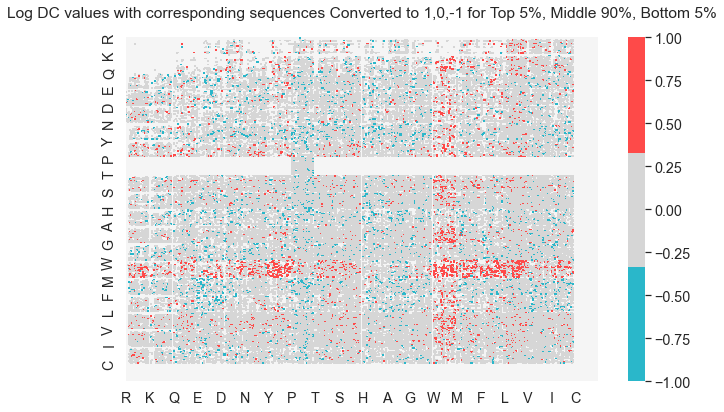

In [8]:
TITLE = 'Log DC values with corresponding sequences Converted to 1,0,-1 for Top 5%, Middle 90%, Bottom 5%'
transformed_20_20_plot = helper_functions.ttplot(pred_df_gt.index, pred_df_gt['combined_gt'].values, title=TITLE)
transformed_20_20_plot.tight_layout()
transformed_20_20_plot.savefig('20x20_log_dc_transformed.png')

This part worked!


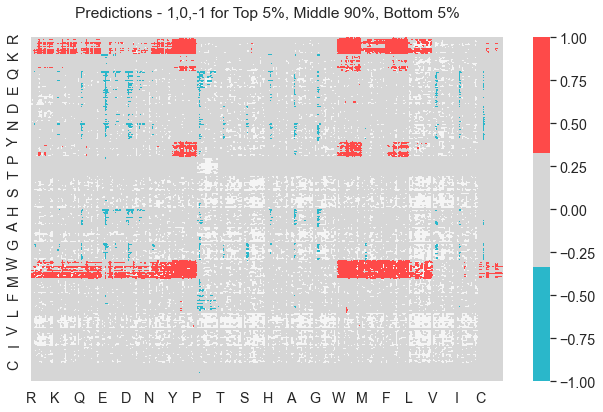

In [9]:
TITLE = 'Predictions - 1,0,-1 for Top 5%, Middle 90%, Bottom 5%'
predictions_20_20_plot = helper_functions.ttplot(pred_df_pred.index, pred_df_pred['combined_pred'].values, title=TITLE)
predictions_20_20_plot.tight_layout()
predictions_20_20_plot.savefig('20x20_pred_combined.png')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
<ipython-input-10-621208757031>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pred_df_pred = pred_df_filtered[pred_df['log.label'].isna() ]


This part worked!


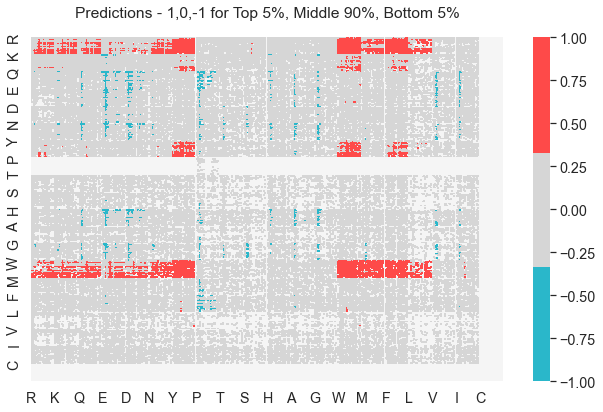

In [10]:
# Filter for PXXX and C:
filter_c_pxxx = pred_df.index.str.contains('(^P[^P])|([C])')
idx_inverted = pred_df[~filter_c_pxxx].index.to_list()
pred_df_filtered = pred_df.loc[idx_inverted, :]
pred_df_pred = pred_df_filtered[pred_df['log.label'].isna()]

TITLE = 'Predictions - 1,0,-1 for Top 5%, Middle 90%, Bottom 5%'
predictions_20_20_plot = helper_functions.ttplot(pred_df_pred.index, pred_df_pred['combined_pred'].values, title=TITLE)
predictions_20_20_plot.tight_layout()
predictions_20_20_plot.savefig('20x20_pred_combined_filtered.png')

## Reasoning for 0.5 Threshold for Predictions

* Visualize the distribution of predictions 

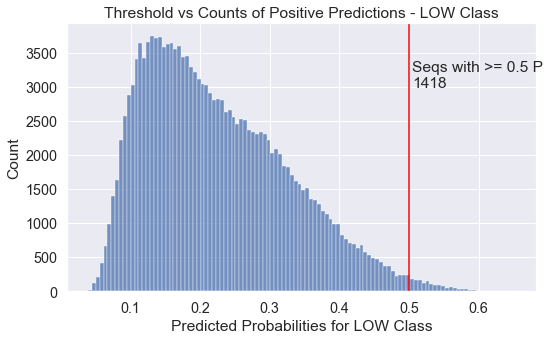

In [45]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(pred_df['low_probs'], cumulative=False, ax=ax)
ax.axvline(x=0.5, color='red')
plt.text(0.505, 3000, s = f'Seqs with >= 0.5 P\n{np.count_nonzero(pred_df_filtered["low_probs"] >= 0.5)}', fontsize='medium')
plt.title('Threshold vs Counts of Positive Predictions - LOW Class')
plt.xlabel('Predicted Probabilities for LOW Class')
plt.tight_layout()
plt.savefig('threshold-low.png')

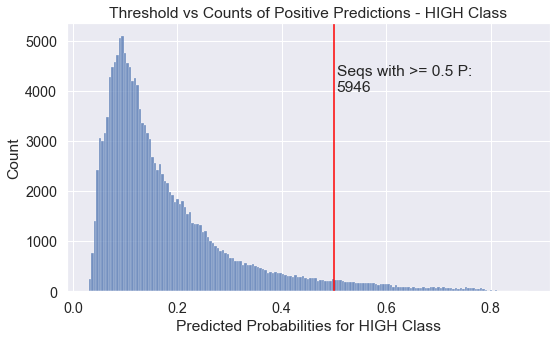

In [46]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(pred_df['high_probs'], cumulative=False, ax=ax)
ax.axvline(x=0.5, color='red')
plt.text(0.505, 4000, s = f'Seqs with >= 0.5 P:\n{np.count_nonzero(pred_df_filtered["high_probs"] >= 0.5)}', fontsize='medium' )
plt.title('Threshold vs Counts of Positive Predictions - HIGH Class')
plt.xlabel('Predicted Probabilities for HIGH Class')
plt.tight_layout()
plt.savefig('threshold-high.png')

### 5% of 160,000 => 8000 sequences.

Our current threshold allows us to get a similar # of sequences for atleast the high group. 
This is also based on the highest F1-score we can get given the various thresholds availables between the two models. We also match the thresholds to keep predictions consistent. 

Figure: 

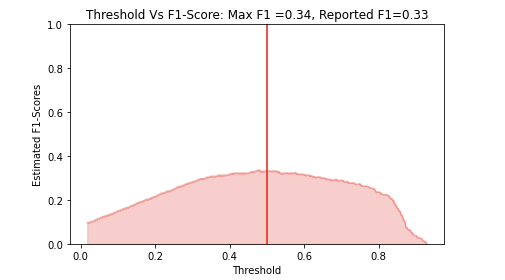

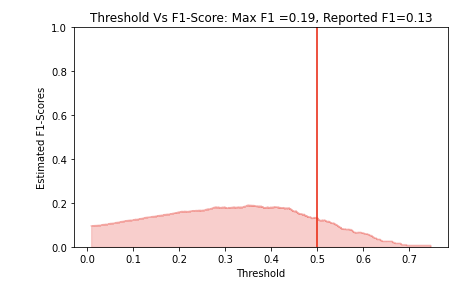